In [1]:
import copy
import os
import random

import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from cmmrt.projection.data import get_representatives
from cmmrt.rt.predictions import load_cmm_predictions
from cmmrt.projection.models.projector.loader import _load_projector_pipeline_from

/home/ernesto12/.local/lib/python3.10/site-packages/tqdm-4.65.0-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_ppm_error(mass, ppm_error=10):
    return (round(mass) * ppm_error) / 10 ** 6

In [3]:
def rank_ind(train, outname='Candidate.csv'):
    x, y = (
        torch.from_numpy(train.prediction.values.reshape(-1, 1)),
        torch.from_numpy(train.rt.values*60)
            )
    projector.projector.prepare_metatesting()
    projector.fit(x, y)
    mass_error_seed = 123
    if mass_error_seed is not None:
        np.random.seed(mass_error_seed)

        candidates_list = []

    for index, row in data_to_rank.iterrows():
        # Skip if the compound is not in the test set (since it wouldn't have a chance to be in the top results)
        error = get_ppm_error(row.calc_mw)
        candidates = predicted_pubchem[
            (predicted_pubchem["ExactMass"] >= (row.calc_mw - error))
            & (predicted_pubchem["ExactMass"] <= (row.calc_mw + error))
            ].copy()

        candidates = candidates.drop(['Unnamed: 0', 'pid', 'MolecularWeight', 'cmm_id'], axis=1)
        candidates = candidates.rename(columns={'prediction':'rt_predicted'})

        if candidates.shape[0] > 0:
            candidates['FeatureID'] = row.FeatureID
            candidates['rt_experimental'] = row.rt*60
            candidates['mass_experimental'] = row.calc_mw
            candidates['z_score'] = pd.NA
            candidates['mass_error'] = abs(candidates.ExactMass - row.calc_mw)
            # add small noise to unbreak ties
            candidates['mass_error'] = candidates['mass_error'] + np.random.uniform(0, 1e-6, candidates.shape[0])
            candidates.sort_values(by='mass_error', inplace=True)
            scores = projector.z_score(candidates[['rt_predicted']].values, np.array([row.rt*60]))
            scores = scores.cpu().numpy()
            candidates.loc[:, 'z_score'] = scores
            candidates.sort_values("z_score", inplace=True)
            candidates = candidates.nlargest(3, ['z_score'])
            candidates_list.append(candidates)

    candidates_final = pd.concat(candidates_list).reset_index(drop=True)
    candidates_final = candidates_final[['FeatureID', 'mass_experimental', 'rt_experimental', 
                                         'rt_predicted', 'mass_error', 'z_score', 'Title', 'MolecularFormula',
                                         'ExactMass', 'InChIKey', 'InChI']]

    candidates_final.to_csv('results/' + outname)

## Adding own data

In [4]:
pubchem_db = pd.read_csv('data/final_pubchem_results.csv')
pubchem_db = pubchem_db.astype({'CID': 'str'})

predicted_pubchem = pd.read_csv('results/predicted_rt_db.csv')
predicted_pubchem = predicted_pubchem.astype({'pid': 'str'})
predicted_pubchem = predicted_pubchem.merge(pubchem_db, left_on='pid', right_on='CID', how='left')

In [5]:
data_to_rank = pd.read_csv('data/RP_virocell_all.csv')
data_annotated = pd.read_csv('data/RP_virocell_id.csv')
data_annotated = data_annotated.astype({'CID': 'str'})
# data_annotated = data_annotated.merge(pubchem_db, left_on='Name', right_on='Title', how='left')
data_to_rank.head()

,FeatureID,Name,Formula,calc_mw,mz,rt,annot_source,Annot. Source: mzVault Search
0,Feature2004,Adenosine,C10 H13 N5 O4,267.09675,268.10403,6.073,mzVault and mzCloud,Full match
1,Feature2003,(S)-(−)-α-Methylbenzylamine,C8 H11 N,104.06255,122.09637,7.339,mzVault and mzCloud,Invalid mass
2,Feature2002,D-Threonine,C4 H9 N O3,119.05819,120.06547,1.337,mzVault and mzCloud,Full match
3,Feature2001,Cytidine-5'-monophosphate,C9 H14 N3 O8 P,323.05191,324.05918,1.606,mzVault and mzCloud,Full match
4,Feature2000,L-Leucine,C6 H13 N O2,131.09459,132.10187,4.156,mzVault and mzCloud,Full match


In [6]:
projector = _load_projector_pipeline_from(f"results/train_projectors/p2e_zero_rbf+linear_4e03_-1_10", mean='zero',
                                          kernel='rbf+linear')
pubchems = np.array(data_annotated.CID)

In [9]:
train_logical = data_annotated['CID'].isin(pubchems)
train = data_annotated[train_logical]
train = train.merge(predicted_pubchem, on='CID', how='left').dropna()
index_list = range(0, train.shape[0])
print(len(index_list))
ii = random.sample(index_list, 46)
train_filt = train.iloc[ii]
train_filt.shape

1


ValueError: Sample larger than population or is negative

In [8]:
rank_ind(train_filt, outname='Candidates_virocell.csv')

NameError: name 'train_filt' is not defined

In [ ]:
 x, y = (
        torch.from_numpy(train.prediction.values.reshape(-1, 1)),
        torch.from_numpy(train.rt.values*60)
            )

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


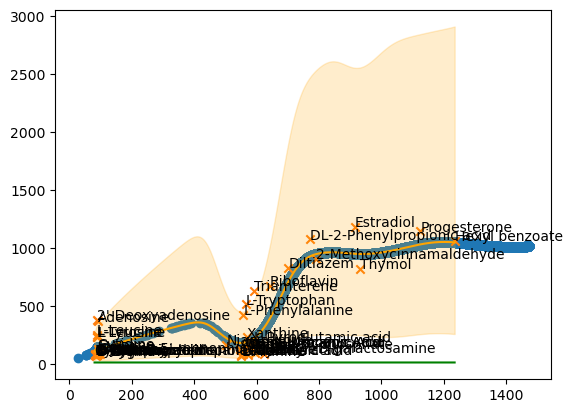

In [ ]:
sorted_x = torch.arange(x.min() - 0.5, x.max() + 0.5, 0.1, dtype=torch.float32)
plt.scatter(predicted_pubchem.prediction.values,
            projector.predict(predicted_pubchem.prediction.values)[0])
plt.scatter(x, y, marker='x')
for i,txt in enumerate(train.Name):
    plt.text(x=x[i], y=y[i], s=train.Name.values[i])
preds_mean, lb, ub = projector.predict(sorted_x)
plt.fill_between(sorted_x, lb, ub, alpha=0.2, color='orange')
plt.plot(sorted_x, preds_mean, color='orange')
with torch.no_grad():
    sorted_x_ = torch.from_numpy(projector.x_scaler.transform(sorted_x.numpy().reshape(-1, 1)))
    tmp = projector.projector.gp.mean_module(sorted_x_)
    tmp = projector.y_scaler.inverse_transform(tmp.reshape(-1, 1)).flatten()
    plt.plot(sorted_x, tmp, color='green')
plt.savefig('results/projection_plot_virocell.png')
plt.show()

### Training using only a hand-selected subset

In [ ]:
train.head()

,FeatureID,Name,Formula,calc_mw,mz,rt,annot_source,Annot. Source: mzVault Search,CID,Unnamed: 0,pid,cmm_id,prediction,Title,MolecularFormula,MolecularWeight,ExactMass,InChIKey,InChI
0,Feature2004,Adenosine,C10 H13 N5 O4,267.09675,268.10403,6.073,mzVault and mzCloud,Full match,60961,110655.0,60961,111256.0,90.843800,Adenosine,C10H13N5O4,267.24,267.096754,OIRDTQYFTABQOQ-KQYNXXCUSA-N,InChI=1S/C10H13N5O4/c11-8-5-9(13-2-12-8)15(3-1...
1,Feature2002,D-Threonine,C4 H9 N O3,119.05819,120.06547,1.337,mzVault and mzCloud,Full match,69435,149919.0,69435,150648.0,87.555220,D-threonine,C4H9NO3,119.12,119.058243,AYFVYJQAPQTCCC-STHAYSLISA-N,"InChI=1S/C4H9NO3/c1-2(6)3(5)4(7)8/h2-3,6H,5H2,..."
2,Feature2001,Cytidine-5'-monophosphate,C9 H14 N3 O8 P,323.05191,324.05918,1.606,mzVault and mzCloud,Full match,6131,132427.0,6131,133031.0,91.340160,Cytidine-5'-monophosphate,C9H14N3O8P,323.20,323.051851,IERHLVCPSMICTF-XVFCMESISA-N,InChI=1S/C9H14N3O8P/c10-5-1-2-12(9(15)11-5)8-7...
3,Feature2000,L-Leucine,C6 H13 N O2,131.09459,132.10187,4.156,mzVault and mzCloud,Full match,6106,51489.0,6106,52074.0,87.360730,Leucine,C6H13NO2,131.17,131.094629,ROHFNLRQFUQHCH-YFKPBYRVSA-N,"InChI=1S/C6H13NO2/c1-4(2)3-5(7)6(8)9/h4-5H,3,7..."
4,Feature1999,D-Valine,C5 H11 N O2,117.07892,118.08620,1.970,mzVault and mzCloud,Full match,71563,158724.0,71563,161242.0,95.302216,D-Valine,C5H11NO2,117.15,117.078979,KZSNJWFQEVHDMF-SCSAIBSYSA-N,"InChI=1S/C5H11NO2/c1-3(2)4(6)5(7)8/h3-4H,6H2,1..."


In [ ]:
selected_metabolites = ['Hexyl benzoate', 'Progesterone', 'Estradiol', 'DL-2-Phenylpropionic acid', '2-Methoxycinnamaldehyde',
                       'Diltiazem', 'RiboFlavin', 'L-Tryptophan', 'L-Phenylalanine', 'Niancinamide',
                       'L-Leucine', 'Cytidine']

train_filt = train.loc[[x in selected_metabolites for x in train['Name']],]
train_filt.shape

(11, 19)

In [ ]:
rank_ind(train_filt, outname='Candidates_virocell_hand_selected.csv')

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to 

In [ ]:
 x, y = (
        torch.from_numpy(train_filt.prediction.values.reshape(-1, 1)),
        torch.from_numpy(train_filt.rt.values*60)
            )

/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/linear_operator-0.3.0-py3.9.egg/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


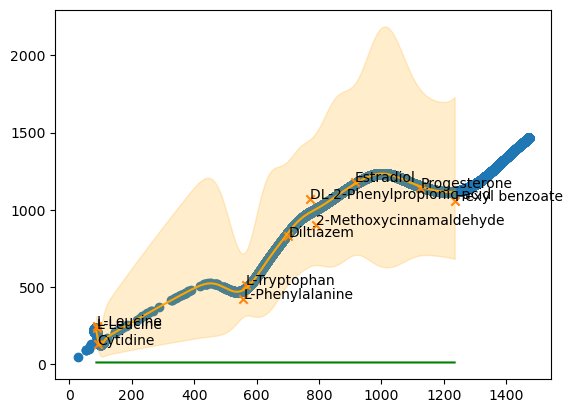

In [ ]:
projector.projector.prepare_metatesting()
projector.fit(x, y)
sorted_x = torch.arange(x.min() - 0.5, x.max() + 0.5, 0.1, dtype=torch.float32)
plt.scatter(predicted_pubchem.prediction.values,
            projector.predict(predicted_pubchem.prediction.values)[0])
plt.scatter(x, y, marker='x')
for i,txt in enumerate(train_filt.Name):
    plt.text(x=x[i], y=y[i], s=train_filt.Name.values[i])
preds_mean, lb, ub = projector.predict(sorted_x)
plt.fill_between(sorted_x, lb, ub, alpha=0.2, color='orange')
plt.plot(sorted_x, preds_mean, color='orange')
with torch.no_grad():
    sorted_x_ = torch.from_numpy(projector.x_scaler.transform(sorted_x.numpy().reshape(-1, 1)))
    tmp = projector.projector.gp.mean_module(sorted_x_)
    tmp = projector.y_scaler.inverse_transform(tmp.reshape(-1, 1)).flatten()
    plt.plot(sorted_x, tmp, color='green')
plt.savefig('results/projection_plot_virocell_hand_selected.png')
plt.show()